# HW3 Making Waves: CDIP Dataset Tutorial and Use Case Examples
### View and evaluating wave height and temperature from the Coastal Data Information Program

## EDS 220, Fall 2021

#### Authors
Cullen Molitor, UC Santa Barbara (cullen_molitor@bren.ucsb.edu)
https://cullen-molitor.github.io/  
Jake Eisaguirre, UC Santa Barbara (eisaguirre@bren.ucsb.edu)
https://jake-eisaguirrer.github.io/  
Marie Rivers, UC Santa Barbars (mrivers@bren.ucsb.edu)
https://marierivers.github.io/

## Table of Contents

[1. Purpose](#purpose)

[2. Dataset Description](#data_description)

[3. Data Input/Output](#io)

[4. Metadata Display](#metadata)

[5. Basic Visualization](#visualize)

[6. Use Case Examples](#usecases)

[7. References](#references)

<a id='purpose'></a> 
### Notebook Purpose

This notebook was created to provide an introduction to NetCDF4 files and data from the [Coastal Data Information Program (CDIP)](https://cdip.ucsd.edu/) at the [Scripps Institute of Oceanography (SIO)](https://scripps.ucsd.edu/). This tutorial is based on a [python API](https://cdip.ucsd.edu/m/documents/data_access.html) which loads netCDF files. We also provide methods for using sea surface temperature and swell height to compare correlations with El Nino/Southern Oscillation (ENSO) behavior at a specific location.

While these methods are applicable to other [CDIP wave buoy stations](https://cdip.ucsd.edu/m/deployment/station_view/), we chose the [Harvest Buoy (CDIP site)](http://cdip.ucsd.edu/themes/?d2=p9:s:71:st:1:m:mobile) to get information close to our local Santa Barabra, CA coast. The metadata is documented on the [CDIP informational site](https://cdip.ucsd.edu/m/documents/intro.html#).

<div>
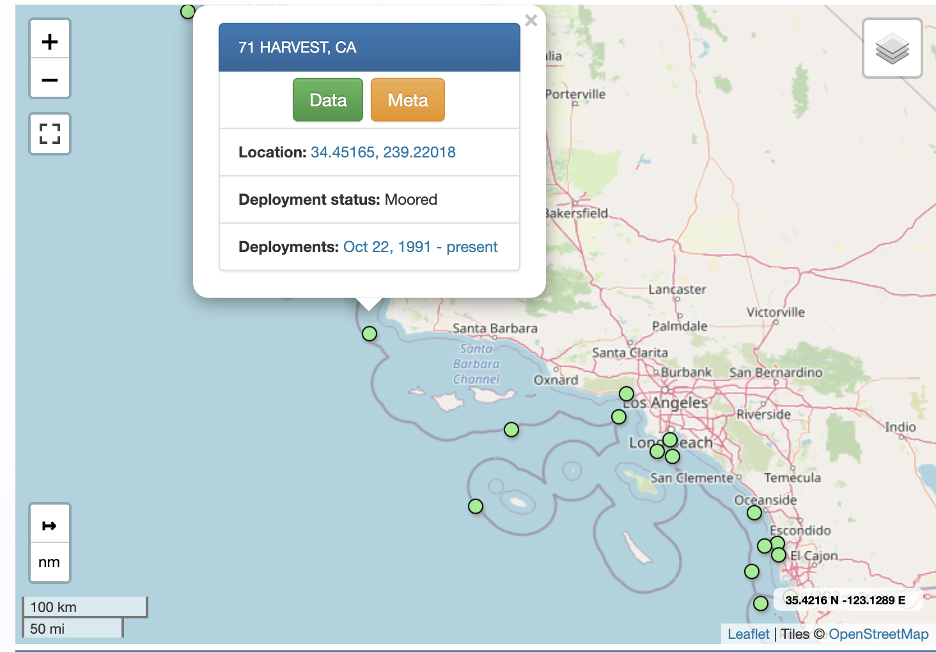  
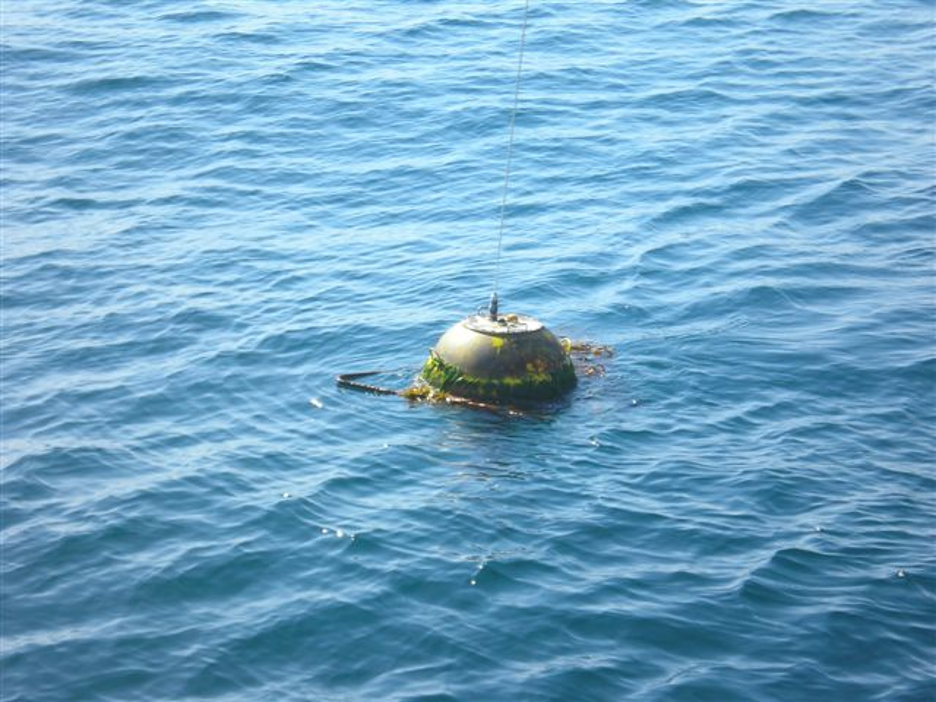
</div>

<a id='data_description'></a> 
### Dataset Description
**File format:** NetCDF  
**Data retrieval source:** CDIP portal and CDIP Python API
 
**Operator:** CDIP  
**Collaborators:** CleanSeas  
**Funding:** California Division of Boating and Waterways (CDBW) & US Army Corps of Engineer (USACE)

**Data Availability:** CDIP data and products are free available for public use  
**License:** These data may be redistributed and used without restriction

**Global coverage of stations:**  
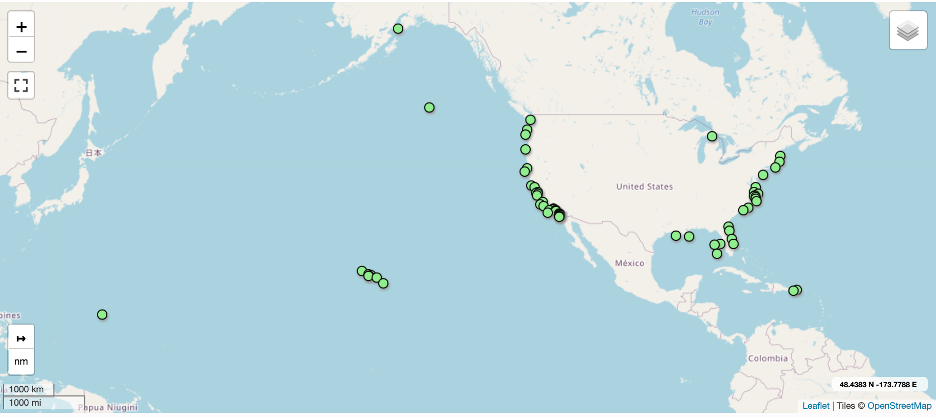

**Harvest buoy period of record:** October 1991 - present  

#### Measured wave parameters
- Hs = wave height, 30-minute average of the ⅓ highest waves at a sensor*
- Tp = peak period (most common period between consecutive waves)
- Dp = peak direction (most common direction)
*Statistically, highest wave during the measurement period ~1.8 x Hs

<div>
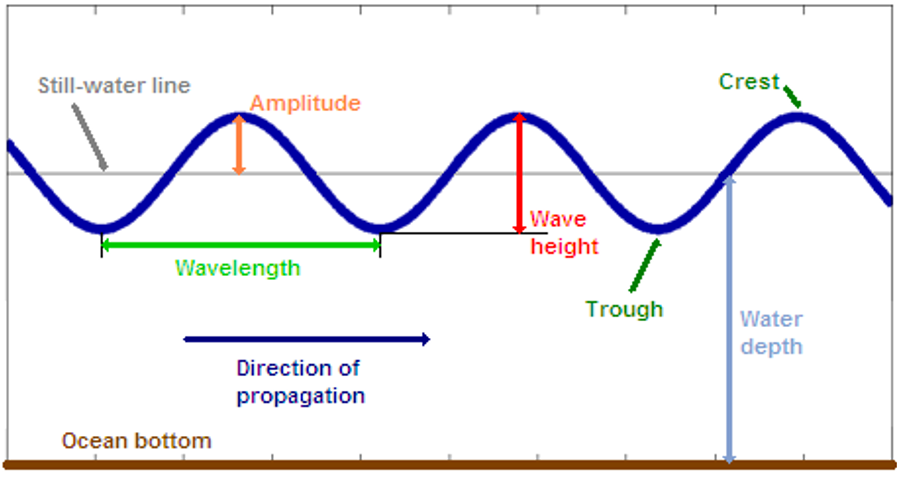
</div>

#### Temporal notes
-  Wave calcs use ~30 minute data samples
- Time assigned to the data is start time
- All data collected is archived by UTC time

#### Data Quality
- high quality publically released data excludes all records flagged by quality control procedures
- activity log documents deployments, transmission problems, maintenance issues, and battery/power failures

<a id='io'></a> 
### Dataset Input/Output 

#### Import required packages

<div>
<im src="Documents/UCSB_Environmental_Data_Science/EDS_220_Remote_Sensing_and_Environmental_Data/220_group_project/mk-waves-tutorial/images/havest.png"/>
</div>



In [2]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import calendar
import pandas as pd
from matplotlib import gridspec
from matplotlib import cm
import matplotlib as mpl

#### Set parameters
- names of any directories where data are stored
- ranges of years over which data are valid
- any thresholds or latitude/longitude ranges to be used later (e.g. dimensions of NINO3.4 region, threshold SSTA values for El Nino, etc.)

[Link to other buoy stations](https://cdip.ucsd.edu/m/deployment/station_view/)

In [3]:
# Type
stn = '071'
# startdate = "01/01/2014"
# enddate = "12/30/2016"

#### Read in the data
we use the `netCDF4` module to read in the archived buoy data.

In [4]:
# CDIP Archived Dataset URL
data_url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/' + stn + 'p1/' + stn + 'p1_historic.nc'

In [5]:
data = netCDF4.Dataset(data_url)

<a id='metadata'></a> 
#### Display metadata

In [6]:
# return the file type
type(data)

netCDF4._netCDF4.Dataset

In [7]:
# return a summary of the dataset
data.summary

'Directional wave and sea surface temperature measurements collected in situ by Datawell Waverider buoys located near HARVEST, CA from 1991/10/22 to 2019/06/17. This dataset includes publicly-released data only, excluding all records flagged bad by quality control procedures. A total of 372110 wave samples were analyzed for this area, where the water depth is approximately 183 to 549 meters.'

In [8]:
# return all variables included in the dataset
print(data.variables.keys())

dict_keys(['sourceFilename', 'waveTime', 'waveTimeBounds', 'waveFlagPrimary', 'waveFlagSecondary', 'waveHs', 'waveTp', 'waveTa', 'waveDp', 'wavePeakPSD', 'waveTz', 'waveSourceIndex', 'waveFrequency', 'waveFrequencyBounds', 'waveFrequencyFlagPrimary', 'waveFrequencyFlagSecondary', 'waveBandwidth', 'sstTime', 'sstTimeBounds', 'sstFlagPrimary', 'sstFlagSecondary', 'sstSeaSurfaceTemperature', 'sstSourceIndex', 'sstReferenceTemp', 'gpsTime', 'gpsTimeBounds', 'gpsStatusFlags', 'gpsLatitude', 'gpsLongitude', 'gpsSourceIndex', 'dwrTime', 'dwrTimeBounds', 'dwrSourceIndex', 'dwrBatteryLevel', 'dwrZAccelerometerOffset', 'dwrXAccelerometerOffset', 'dwrYAccelerometerOffset', 'dwrOrientation', 'dwrInclination', 'dwrBatteryWeeksOfLife', 'metaDeployLatitude', 'metaDeployLongitude', 'metaWaterDepth', 'metaDeclination', 'metaStationName', 'metaStationLatitude', 'metaStationLongitude', 'metaPlatform', 'metaInstrumentation', 'metaGridMapping', 'waveEnergyDensity', 'waveMeanDirection', 'waveA1Value', 'wave

The Harvest buoy collects data in the following categories:

- Significant Wave Height  
- Swell Height 
- Swell Period 
- Swell Direction 
- Wind Wave Height 
- Wind Wave Period 
- Wind Wave Direction 
- Wave Steepness 
- Average Wave Period 
- Water Temperature

We are interested in:

- Significant Wave Height (`waveHs`)
- Sea Surface Temperatuer (`sstSeaSurfaceTemperature`)

In [9]:
# learn more about a variable including long name, units, valid min/max values
print(data['sstSeaSurfaceTemperature'])

<class 'netCDF4._netCDF4.Variable'>
float32 sstSeaSurfaceTemperature(sstTime)
    long_name: sea surface temperature
    units: Celsius
    _FillValue: -999.99
    standard_name: sea_surface_temperature
    coordinates: metaStationLatitude metaStationLongitude
    grid_mapping: metaGridMapping
    valid_min: -5.0
    valid_max: 46.15
    ancillary_variables: sstFlagPrimary sstFlagSecondary
    ncei_name: SEA SURFACE TEMPERATURE
    cell_methods: sstTime: point
unlimited dimensions: 
current shape = (372015,)
filling off


In [10]:
# Other Variables
# data.variables
# Hs = data.variables['waveHs']
# Tp = data.variables['waveTp']
# Dp = data.variables['waveDp'] 

#### Clean data

[Example code found here](http://cdip.ucsd.edu/themes/?zoom=auto&tz=UTC&ll_fmt=dm&numcolorbands=100&palette=cdip_classic&high=4.572&r=7&un=1&pb=1&d2=p70&u2=s:071:st:1:v:product_descriptions)

In [11]:
# Get SST timestamp variable 
sst_time_var = data.variables['sstTime']

# Get SST variable 
sst = data.variables['sstSeaSurfaceTemperature'][:]

# Get wave height timestamp variable
wave_time_var = data.variables['waveTime']

# Get wave height variable 
wave = data.variables['waveHs'][:]

We used the cftime Python library for decoding time units and variable values in a netCDF file conforming to the Climate and Forecasting (CF) netCDF conventions.

[cftime documentation](https://unidata.github.io/cftime/)

First we created dataframes for the sea surface temperature and wave data. We then aggregatted this data by month and joined the dataframes to create one dataframe of buoy variables.

In [12]:
# Use num2date on sst_time_var
sst_time = netCDF4.num2date(sst_time_var[:], sst_time_var.units, only_use_cftime_datetimes=False)

In [13]:
# Make an empty pandas dataframe
sst_df = pd.DataFrame()

# Fill it with SST and the date time it was collected
sst_df['sst'] = sst
sst_df['date_time'] = sst_time

In [14]:
# Make date_time column a pandas date_time
sst_df['date_time'] = pd.to_datetime(sst_df['date_time']) 

# Pull out date from datetime
sst_df['date'] = sst_df['date_time'].dt.date

# Pull out month from datetime
sst_df['month'] = sst_df['date_time'].dt.month

# Pull out year from datetime
sst_df['year'] = sst_df['date_time'].dt.year

In [15]:
# Use num2date on wave_time_var
wave_time = netCDF4.num2date(wave_time_var[:], wave_time_var.units, only_use_cftime_datetimes=False)

In [16]:
# Make an empty pandas dataframe
wave_df = pd.DataFrame()

# Fill it with SST and the date time it was collected
wave_df['wave'] = wave
wave_df['date_time'] = wave_time

In [17]:
# Make date_time column a pandas date_time
wave_df['date_time'] = pd.to_datetime(wave_df['date_time']) 

# Pull out date from datetime
wave_df['date'] = wave_df['date_time'].dt.date

# Pull out month from datetime
wave_df['month'] = wave_df['date_time'].dt.month

# Pull out year from datetime
wave_df['year'] = wave_df['date_time'].dt.year

In [18]:
# Inspect data
sst_df.head()
wave_df.head()

,wave,date_time,date,month,year
0,1.50,1991-10-22 07:52:00,1991-10-22,10,1991
1,1.48,1991-10-22 08:22:00,1991-10-22,10,1991
2,1.54,1991-10-22 08:52:00,1991-10-22,10,1991
3,1.56,1991-10-22 09:22:00,1991-10-22,10,1991
4,1.59,1991-10-22 09:52:00,1991-10-22,10,1991


<a id='visualize'></a> 
### Visualize data

We started by visualizing the full dataset to inform our further analysis. Based on the data gaps shown in the plot above, we decided to begin our analysis at 1997.

Text(0, 0.5, 'SST, C')

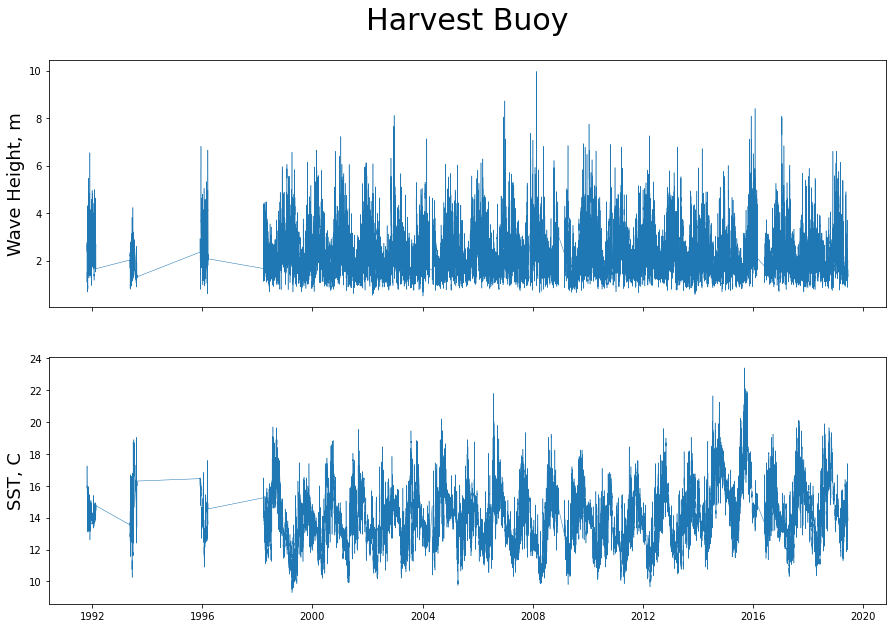

In [19]:
# Plot here to see what the data looks like
f, (pHs, pSst) = plt.subplots(2, 1, sharex=True, figsize=(15,10)) 
pSst.plot(sst_df.date, sst_df.sst, linewidth = 0.5)
pHs.plot(wave_df.date, wave_df.wave, linewidth = 0.5)
plt.title("Harvest Buoy", fontsize=30, y = 2.3)
pHs.set_ylabel('Wave Height, m', fontsize=18)
pSst.set_ylabel('SST, C', fontsize=18)

<a id='usecases'></a> 
### Use Cases Examples

### Observational Data vs Modeled Data

The CDIP buoy network is a valuable resource for marine scientists, coastal managers, and mariners. The **historic data** (observational) is archived and is of great use for understanding past patterns and provides context for understanding the oceanographic conditions of our local ocean. **Real time data** (observaltional) gives an better idea of what to expect as wave energy moves past the buoy and towards our shorline. It is also incredibly useful for mariners navigating these sometimes harsh and volotile waters. Forecasted data (modeled) is perhaps the most practical use case for mariners, as they not only need to know the current conditions but they need to know how those conditions are changing in order to navigate safely. 

CDIP provide what they call ['nowcasted' data and 'forecasted' data](https://cdip.ucsd.edu/m/documents/models.html#about-the-cdip-wave-forecast-model). 
- Nowcasted provides insight at a higher resolution for the upcoming 6-hour period. These predictions tend to be more accurate and are generally fairly trustworthy. 
- Forecasted data provide a look further into the future, but with a greater amount of uncertainty  

### Our interest

We are interested in investigating the effect of El Niño on our local oceanographic conditions. We used linear regression models to plot and compare equetorial sea surface temperature anomalies with local Santa Barbara temperature and wave height. Typically temperature anamolies are calcuated from a 30 year base period. Since we only had ~20 years of consistent data, we calculated monthly means since 1997 and used these as base values from which to compare monthly means for each year. The results of this analysis are useful to scientist, marine managers, marine conservation groups and coastal communities.

### Other General Use Cases

- Modeling coastal errosion 
- Investigating storm frequecny and intensity over time
- Investigating changes in SST over time
- Detecting upwelling events

In [20]:
# Filter data to be greater than 1997 to dump missing values
sst_df = sst_df[sst_df['year'] > 1997]

wave_df = wave_df[wave_df['year'] > 1997]

In [23]:
# Group by date and summarise with mean SST and Wave Height
sst_monthly = sst_df.groupby(['month', 'year']).agg({'sst': 'mean'})

wave_monthly = wave_df.groupby(['month', 'year']).agg({'wave': 'mean'})

In [24]:
# Inspect Data
print(sst_monthly.head())
print(wave_monthly.head())

                  sst
month year           
1     1999  13.194914
      2000  13.023686
      2001  13.454234
      2002  12.896236
      2003  14.313378
                wave
month year          
1     1999  2.467315
      2000  2.126410
      2001  2.971848
      2002  2.609128
      2003  2.432630


In [25]:
# join monthly sst and wave data into a buoy dataframe
buoy_df = sst_monthly.join(wave_monthly)
buoy_df

sst      wave
month year                     
1     1999  13.194914  2.467315
      2000  13.023686  2.126410
      2001  13.454234  2.971848
      2002  12.896236  2.609128
      2003  14.313378  2.432630
...               ...       ...
12    2014  16.786358  2.756734
      2015  15.884072  3.330739
      2016  13.688676  2.353851
      2017  15.000236  2.022722
      2018  15.179164  2.877026

[252 rows x 2 columns]

Next we used `reset_index` to ungroup the data

In [26]:
buoy_df = buoy_df.reset_index()
buoy_df

,month,year,sst,wave
0,1,1999,13.194914,2.467315
1,1,2000,13.023686,2.126410
2,1,2001,13.454234,2.971848
3,1,2002,12.896236,2.609128
4,1,2003,14.313378,2.432630
...,...,...,...,...
247,12,2014,16.786358,2.756734
248,12,2015,15.884072,3.330739
249,12,2016,13.688676,2.353851
250,12,2017,15.000236,2.022722


In [27]:
# calculate the anomalies
buoy_df = buoy_df.groupby(['month', 'year']).agg({'sst': 'mean', 'wave': 'mean'}) - \
    buoy_df.groupby(['month']).agg({'sst': 'mean', 'wave': 'mean'}) 
buoy_df.head()

# since this line of code was so long, use used a `\` to break up the line. You can also split up lines at commas

sst      wave
month year                    
1     1999 -0.458099 -0.088380
      2000 -0.629327 -0.429286
      2001 -0.198779  0.416153
      2002 -0.756777  0.053433
      2003  0.660365 -0.123065

Note: You need to reset the index each time you group the data

In [28]:
buoy_df = buoy_df.reset_index()
buoy_df

,month,year,sst,wave
0,1,1999,-0.458099,-0.088380
1,1,2000,-0.629327,-0.429286
2,1,2001,-0.198779,0.416153
3,1,2002,-0.756777,0.053433
4,1,2003,0.660365,-0.123065
...,...,...,...,...
247,12,2014,2.599428,0.120727
248,12,2015,1.697143,0.694733
249,12,2016,-0.498254,-0.282156
250,12,2017,0.813306,-0.613285


In [29]:
# rename columns
buoy_df = buoy_df.rename(columns = {'sst':'buoy_sst_anom', 'wave':'buoy_wave_anom'})

# set datetime 
buoy_df = buoy_df.assign(day = 1)
buoy_df['date'] = pd.to_datetime(buoy_df[['year', 'month', 'day']])
buoy_df = buoy_df.sort_values(by=['date'])
buoy_df = buoy_df.set_index('date')

In [30]:
buoy_df

,month,year,buoy_sst_anom,buoy_wave_anom,day
date,,,,,
1998-03-01,3,1998,1.834283,0.105816,1
1998-04-01,4,1998,0.914924,-0.130027,1
1998-05-01,5,1998,0.674051,-0.090042,1
1998-06-01,6,1998,0.614153,-0.300137,1
1998-07-01,7,1998,1.214789,0.132242,1
...,...,...,...,...,...
2019-02-01,2,2019,0.651257,0.147745,1
2019-03-01,3,2019,0.618302,-0.183959,1
2019-04-01,4,2019,1.279213,-0.132941,1


## read in enso data

In [31]:
path = "https://www.cpc.ncep.noaa.gov/data/indices/ersst5.nino.mth.91-20.ascii"
enso = pd.read_csv(path, sep = '\s{2,}', engine = 'python')
enso

,YR,MON,NINO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM.2,NINO3.4,ANOM.3
0,1950,1,23.01,-1.55,23.56,-2.10,26.94,-1.38,24.55,-1.99
1,1950,2,24.32,-1.78,24.89,-1.52,26.67,-1.53,25.06,-1.69
2,1950,3,25.11,-1.38,26.36,-0.84,26.52,-1.80,25.87,-1.42
3,1950,4,23.63,-1.90,26.44,-1.14,26.90,-1.73,26.28,-1.54
4,1950,5,22.68,-1.74,25.69,-1.57,27.73,-1.18,26.18,-1.75
...,...,...,...,...,...,...,...,...,...,...
857,2021,6,22.75,-0.37,26.30,-0.32,28.83,-0.14,27.45,-0.28
858,2021,7,21.74,-0.22,25.49,-0.32,28.67,-0.22,26.91,-0.38
859,2021,8,20.71,-0.30,24.66,-0.46,28.53,-0.26,26.35,-0.51
860,2021,9,20.06,-0.67,24.46,-0.44,28.23,-0.53,26.16,-0.56


In [32]:
# clean ENSO data
enso = enso = enso.drop(enso.columns[[2, 3, 4, 5, 6, 7, 8]], axis=1)
enso = enso.rename(columns={"YR":"year", "MON":"month", "ANOM.3": "enso_anom"})
enso

,year,month,enso_anom
0,1950,1,-1.99
1,1950,2,-1.69
2,1950,3,-1.42
3,1950,4,-1.54
4,1950,5,-1.75
...,...,...,...
857,2021,6,-0.28
858,2021,7,-0.38
859,2021,8,-0.51
860,2021,9,-0.56


In [33]:
enso = enso.assign(day = 1)
enso['date'] = pd.to_datetime(enso[['year', 'month', 'day']])

#### Plot ENSO anomaly

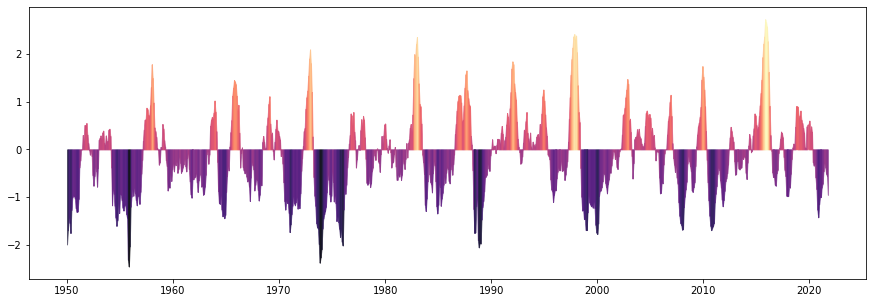

In [34]:
# Choose color gradient here: https://matplotlib.org/stable/tutorials/colors/colormaps.html 

colourmap = cm.get_cmap('magma')

xx = enso.date
yy =  enso.enso_anom

plt.figure(figsize = (15, 5))
plt.plot(xx,yy, color = 'none')

normalize = mpl.colors.Normalize(vmin=yy.min(), vmax=yy.max())
npts = 862
for i in range(npts - 1):
    plt.fill_between([xx[i], xx[i+1]],
                     [yy[i], yy[i+1]],
                     color=colourmap(normalize(yy[i]))
                     ,alpha=0.6)
plt.show()

### Joining enso and buoy data

In [32]:
buoy_df = buoy_df.drop(["month", "year", "day"], axis=1).resent_index()
enso = enso.drop(["year", "month", "day"])

In [33]:
anom_df = 

Text(0, 0.5, 'ENSO Anomaly')

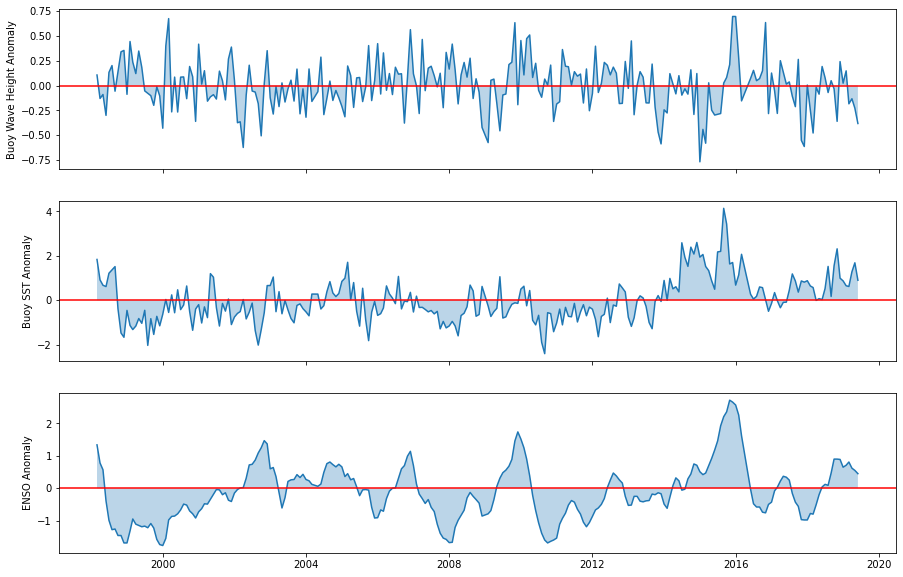

In [34]:
# Plot sst and wave height anomaly from buoy along with ENSO sst anomaly
f, (bwa, bsa, esa ) = plt.subplots(3, 1, sharex=True, figsize=(15,10))

bwa.plot(anom_df.date, anom_df.buoy_wave_anom)
bwa.fill_between(anom_df.date, anom_df.buoy_wave_anom, 0, alpha=0.30)
bwa.axhline(0,color='red')
bwa.set_ylabel('Buoy Wave Height Anomaly')

bsa.plot(anom_df.date, anom_df.buoy_sst_anom)
bsa.fill_between(anom_df.date, anom_df.buoy_sst_anom,  0, alpha=0.30)
bsa.axhline(0,color='red')
bsa.set_ylabel('Buoy SST Anomaly')

esa.plot(anom_df.date, anom_df.enso_anom)
esa.fill_between(anom_df.date, anom_df.enso_anom,  0, alpha=0.30)
esa.axhline(0,color='red')
esa.set_ylabel('ENSO Anomaly')



## Model

In [35]:
import statsmodels.api as sm

In [36]:
# Simple linear model: buoy sst anomaly vs enso sst anomaly
model = 

# Model results
results = 

# Model summary


                                 OLS Regression Results                                
Dep. Variable:          buoy_sst_anom   R-squared (uncentered):                   0.282
Model:                            OLS   Adj. R-squared (uncentered):              0.279
Method:                 Least Squares   F-statistic:                              98.58
Date:                Fri, 19 Nov 2021   Prob (F-statistic):                    8.24e-20
Time:                        17:01:44   Log-Likelihood:                         -312.83
No. Observations:                 252   AIC:                                      627.7
Df Residuals:                     251   BIC:                                      631.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [37]:
# Simple linear model: buoy wave anomaly vs enso sst anomaly
model = 

# Model results
results = 

# Model summary


                                 OLS Regression Results                                
Dep. Variable:         buoy_wave_anom   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.004
Method:                 Least Squares   F-statistic:                           0.006448
Date:                Fri, 19 Nov 2021   Prob (F-statistic):                       0.936
Time:                        17:01:44   Log-Likelihood:                         -11.128
No. Observations:                 252   AIC:                                      24.26
Df Residuals:                     251   BIC:                                      27.79
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [38]:
# Simple linear model: buoy wave anomaly vs buoy sst anomaly
model = 

# Model results
results = 

# Model summary


                                 OLS Regression Results                                
Dep. Variable:         buoy_wave_anom   R-squared (uncentered):                   0.035
Model:                            OLS   Adj. R-squared (uncentered):              0.031
Method:                 Least Squares   F-statistic:                              9.167
Date:                Fri, 19 Nov 2021   Prob (F-statistic):                     0.00272
Time:                        17:01:44   Log-Likelihood:                         -6.6118
No. Observations:                 252   AIC:                                      15.22
Df Residuals:                     251   BIC:                                      18.75
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

#### Visulaize model results

Text(0, 0.5, 'ENSO SST Anomaly')

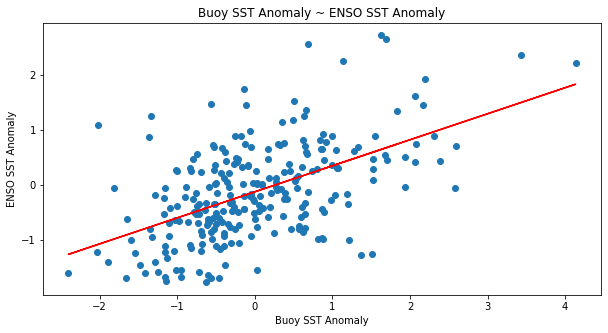

In [39]:
m, b = np.polyfit(anom_df.buoy_sst_anom, anom_df.enso_anom, 1)
plt.figure(figsize = (10, 5))
plt.scatter(anom_df.buoy_sst_anom, anom_df.enso_anom)
plt.plot(anom_df.buoy_sst_anom, m * anom_df.buoy_sst_anom + b, color = 'red')
plt.title('Buoy SST Anomaly ~ ENSO SST Anomaly')
plt.xlabel('Buoy SST Anomaly')
plt.ylabel('ENSO SST Anomaly')

Text(0, 0.5, 'ENSO SST Anomaly')

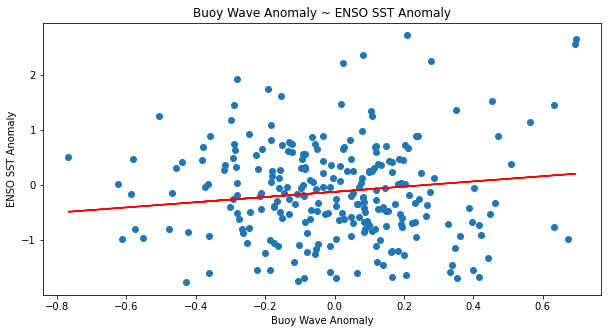

In [40]:
m, b = np.polyfit(anom_df.buoy_sst_anom, anom_df.enso_anom, 1)
plt.figure(figsize = (10, 5))
plt.scatter(anom_df.buoy_wave_anom, anom_df.enso_anom)
plt.plot(anom_df.buoy_wave_anom, m * anom_df.buoy_wave_anom + b, color = 'red')
plt.title('Buoy Wave Anomaly ~ ENSO SST Anomaly')
plt.xlabel('Buoy Wave Anomaly')
plt.ylabel('ENSO SST Anomaly')

Text(0, 0.5, 'Buoy SST Anomaly')

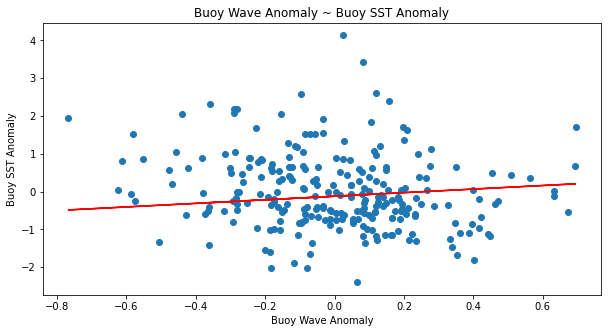

In [41]:
m, b = np.polyfit(anom_df.buoy_sst_anom, anom_df.enso_anom, 1)
plt.figure(figsize = (10, 5))
plt.scatter(anom_df.buoy_wave_anom, anom_df.buoy_sst_anom)
plt.plot(anom_df.buoy_wave_anom, m * anom_df.buoy_wave_anom + b, color = 'red')
plt.title('Buoy Wave Anomaly ~ Buoy SST Anomaly')
plt.xlabel('Buoy Wave Anomaly')
plt.ylabel('Buoy SST Anomaly')

### Results
Our model shows a positive correlation between ENSO sea surface temperature anomaly and Santa Barbara sea surface temperature anomaly. Buoy wave anomaly only has a slight positive correlation with ENSO sea surface temperature anomaly.


#### Future Work
Further analyses with these datasets could look at correlations on a larger spatial scale by comparing results for other buoy stations closer to and further from the equator than Santa Barbara. The CDIP datasets can also be used to model the effect of ENSO on wave direction.

<a id='references'></a> 
### References

References used to create this tutorial include:

1. Coastal Data Information Program (CDIP): https://cdip.ucsd.edu/
2. Coastal Data Information Program (CDIP) data access documentation: https://cdip.ucsd.edu/m/documents/data_access.html
3. Harvest bouy, station 071: https://cdip.ucsd.edu/m/products/?stn=071p1 

**Data citation:** Data furnished by the Coastal Data Information Program (CDIP), Integrative Oceanography Division, operated by the Scripps Institution of Oceanography, under the sponsorship of the U.S. Army Corps of Engineers and the California Department of Parks and Recreation